In [1]:
%reload_ext autoreload
%autoreload 2
import os
import glob
import scipy.io.wavfile as wv
import matplotlib.pyplot as plt
import numpy as np
from util import util
import scipy.signal as sig
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [11]:
classes = ['music', 'voice', 'environment']

macDir = '/Volumes/SAA_DATA/datasets/'
winDir = 'E:/SAA_DATA/'
osDir = winDir

baseTargetDir = '/Users/etto/Desktop/pData'
baseTargetDir = 'E:/SAA_DATA/targetDir'

baseSrcDir = osDir + 'localizationFiles/20171025AllExtractionsMic4'
orgWavDirs1 = ['G428_0.0_1.4',
              'G527_0.5_1.4',
              'Studio_2.0_4.2'
              ]

orgWavDirs2 = ['G428_2.1_2.4',
              'G527_1.2_5.8',
              'Studio_3.0_2.0'
              ]

NFFT = 1024

storageFolder = '../storedData/'

In [3]:
# Train alleen op 1 van de org dirs
srcDir = baseSrcDir + '/' + orgWavDirs1[0]
filesPerCategory = {}
for catDirLong in glob.glob(srcDir + '/*'):
    catDir = catDirLong.replace('\\', '/')
    catDir = catDir.replace(srcDir + '/', '')
    
    filesPerCategory[catDir] = []
    for filename in glob.glob(catDirLong + '/*'):
        filename = filename.replace('\\','/')
        filesPerCategory[catDir].append(filename)


In [4]:
# maak spectros van elke file
spectros = {}
for clz in classes:
    spectros[clz] = []
    for filename in filesPerCategory[clz]:
        fs, signal = wv.read(filename)
        freq_array, segment_times, spectrogram = sig.spectrogram(x=signal, fs=fs, nfft=NFFT, noverlap=0)
        spectros[clz].append(spectrogram.T)
        

In [5]:
#alle X achter elkaar in goede volgorde

X_train = np.concatenate(spectros[classes[0]], axis=0)
for i in range(1, len(classes)):
    nwSpectros = np.concatenate(spectros[classes[i]], axis=0)
    X_train = np.concatenate((X_train,nwSpectros), axis=0) 

np.shape(X_train)

(187316, 513)

In [6]:
clzLengths = {}
for clz in classes:
    clzLengths[clz] = sum([np.shape(lst)[0] for lst in spectros[clz]])
print(clzLengths)

{'music': 60205, 'voice': 60859, 'environment': 66252}


In [7]:
# one-hot encoding
clsNr = 0
nrFiles = clzLengths[classes[0]]
Y_train = np.array((np.ones(nrFiles),np.zeros(nrFiles), np.zeros(nrFiles))).T

nrFiles = clzLengths[classes[1]]
Y_train_nw = np.array((np.zeros(nrFiles),np.ones(nrFiles), np.zeros(nrFiles))).T
Y_train = np.concatenate((Y_train, Y_train_nw),axis=0)

nrFiles = clzLengths[classes[2]]
Y_train_nw = np.array((np.zeros(nrFiles),np.zeros(nrFiles), np.ones(nrFiles))).T
Y_train = np.concatenate((Y_train, Y_train_nw),axis=0)
print(np.shape(Y_train))

(187316, 3)


zie https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/

In [8]:
# define baseline model
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(100, input_dim=513, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [9]:
soundModel = create_model()
history = soundModel.fit(X_train, Y_train, epochs=5, shuffle=True, verbose=1)

Epoch 1/5
187316/187316 [==============================] - 20s 109us/step - loss: 0.2136 - acc: 0.9209
Epoch 2/5
187316/187316 [==============================] - 18s 99us/step - loss: 0.1225 - acc: 0.9539
Epoch 3/5
187316/187316 [==============================] - 18s 98us/step - loss: 0.1019 - acc: 0.9615
Epoch 4/5
187316/187316 [==============================] - 18s 98us/step - loss: 0.0892 - acc: 0.9662
Epoch 5/5
187316/187316 [==============================] - 19s 99us/step - loss: 0.0816 - acc: 0.9691


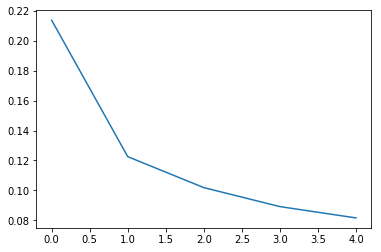

In [10]:
plt.plot(history.history['loss'])
plt.show()

In [12]:
soundModel.save(storageFolder + 'prf1.hd5')

## evalueer op testdata
Waar staat test data?

In [13]:
import WavFileParts